In [1]:
import pandas as pd
import copy
import torch

In [2]:

import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
# alexnet = models.alexnet(pretrained=True)
# squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
# inception = models.inception_v3(pretrained=True)
# googlenet = models.googlenet(pretrained=True)
# shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)

In [3]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
from tddl.factorizations import number_layers
from tddl.factorizations import listify_numbered_layers

/home/jetzeschuurman/gitProjects/phd/tltorch/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [5]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def plot_parameters(model, layers, ):

    pretrained_numbered_layers = number_layers(model)
    pretrained_layers = listify_numbered_layers(pretrained_numbered_layers, layer_nrs=layers)

    params_conv = {
        'name': [],
        'nr': [],
        'parameter_count': [],
        'trainable_parameter_count': [],
    }

    for layer in pretrained_layers:
        name = layer[0]
        nr = layer[1]
        module = layer[2]

        parameter_count = count_parameters(module)
        trainable_parameter_count = count_trainable_parameters(module)
        if parameter_count != trainable_parameter_count:
            print(name, nr)

        params_conv['name'].append(name)
        params_conv['nr'].append(nr)
        params_conv['parameter_count'].append(parameter_count)
        params_conv['trainable_parameter_count'].append(trainable_parameter_count)

    param_count = pd.DataFrame(data=params_conv)
    # print(param_count.name[0])
    param_count.set_index('nr', inplace=True)
    # param_count

    grouped_count = param_count.groupby(by='name')

    # grouped_count['parameter_count'].plot(legend=True, style=".-", ylabel='Parameter Count Per Layer', xlabel='Layer Number')
    grouped_count['parameter_count'].plot(legend=True, style=".-", ylabel='Parameter Count Per Layer (log scale)', xlabel='Layer Number', logy=True)

In [6]:
import tensorly as tl
tl.set_backend('pytorch')

def relative_error(pre_weight, dec_weight):
    with torch.no_grad():
        return tl.norm(pre_weight-dec_weight)/tl.norm(pre_weight)

In [7]:
from tddl.factorizations import factorize_network
decompose_weights=True

In [17]:
def process_factorized_network(model, fact_model, layer_nrs, first_layer_nr=0):

    pretrained_numbered_layers = number_layers(model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers, 
        layer_nrs=layer_nrs
    )

    decomposed_numbered_layers_resnet18 = number_layers(fact_model)
    decomposed_conv_layers_resnet18 = listify_numbered_layers(
        decomposed_numbered_layers_resnet18, 
        layer_nrs=layer_nrs
    )

    errors_conv_resnet18 = {
        'name': [],
        'nr': [],
        'error': [],
    }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers_resnet18):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        print(name)
        nr = pre[1]
        print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        
        errors_conv_resnet18['name'].append(name)
        errors_conv_resnet18['nr'].append(nr)
        errors_conv_resnet18['error'].append(float(error))

    df_errors = pd.DataFrame(data=errors_conv_resnet18)
    if first_layer_nr is not None:
        df_errors.name.iloc[first_layer_nr] = 'in'
    df_errors.set_index('nr', inplace=True)
    grouped_errors = df_errors.groupby(by='name')
    grouped_errors['error'].plot(legend=True, style=".-", ylabel='Relative Error', xlabel='Layer Number')

# ResNet18

In [8]:
resnet18_layers = [0,6,9,12,15,19,22,25,28,31,35,38,41,44,47,51,54,57,60,63]
# excluding linear layer nr: 66

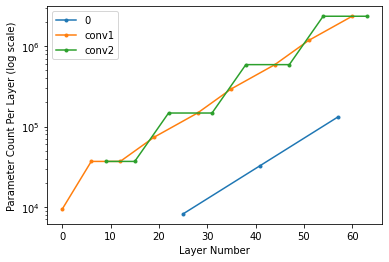

In [9]:
plot_parameters(resnet18, resnet18_layers)

## Tucker

### Rank 50%

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'
/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


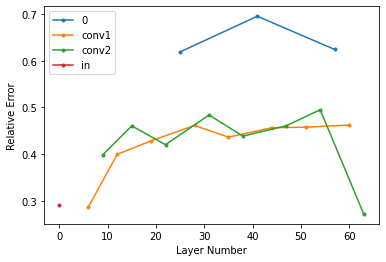

In [10]:
factorization='tucker'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_resnet18 = copy.deepcopy(resnet18)

factorize_network(fact_resnet18, 
    layers=resnet18_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    # return_error=True,
    # verbose=True,
)

process_factorized_network(resnet18, fact_resnet18, layer_nrs=resnet18_layers)

## CP

### Rank 50%

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


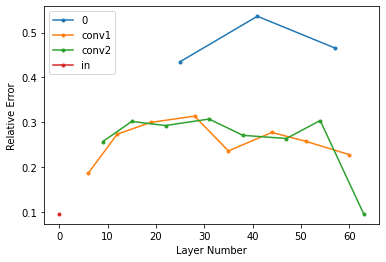

In [11]:
factorization='cp'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_resnet18_cp_50 = copy.deepcopy(resnet18)

factorize_network(
    fact_resnet18_cp_50, 
    layers=resnet18_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    # return_error=True,
    # verbose=True,
)

process_factorized_network(resnet18, fact_resnet18_cp_50, layer_nrs=resnet18_layers)

## TT

### 50%

In [14]:
factorization='tt'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_resnet18_tt_50 = copy.deepcopy(resnet18)

factorize_network(
    fact_resnet18_tt_50, 
    layers=resnet18_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
)

process_factorized_network(resnet18, fact_resnet18_tt_50, layer_nrs=resnet18_layers)

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


RuntimeError: The size of tensor a (7) must match the size of tensor b (64) at non-singleton dimension 3

In [21]:
fact_resnet18_tt_50.conv1.weight.to_tensor().shape

torch.Size([3, 7, 7, 64])

In [22]:
resnet18.conv1.weight.shape

torch.Size([64, 3, 7, 7])

# ResNet50

In [23]:
number_layers(resnet50)

{'conv1': (0,
  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
 'bn1': (1,
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 'relu': (2, ReLU(inplace=True)),
 'maxpool': (3,
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
 'layer1': (4,
  {'0': (5,
    {'conv1': (6,
      Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)),
     'bn1': (7,
      BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
     'conv2': (8,
      Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
     'bn2': (9,
      BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
     'conv3': (10,
      Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)),
     'bn3': (11,
      BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
     'relu': (12, ReLU(inplace=True)),
     'downsample':

In [24]:
resnet50_layers = [0,6,8,10,14,17,19,21,25,27,29,34,36,38,42,45,47,49,53,55,57,61,63,65,70,72,74,78,81,83,85,89,91,93,97,99,101,105,107,109,113,115,117,122,124,126,130,133,135,137,141,143,145]
# excuding the final layer nr: 149

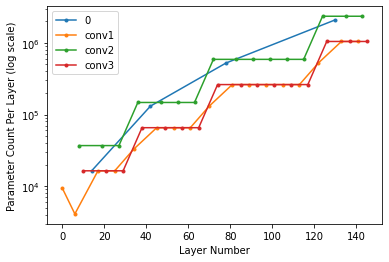

In [27]:
plot_parameters(resnet50, resnet50_layers)


## Tucker

### Rank 50%

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'
/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


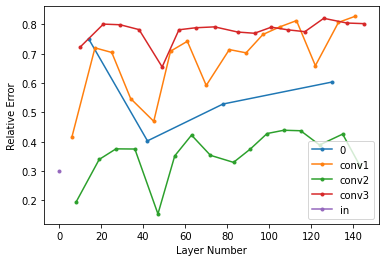

In [25]:
factorization='tucker'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_resnet50_tucker_50 = copy.deepcopy(resnet50)

factorize_network(
    fact_resnet50_tucker_50, 
    layers=resnet50_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
)

process_factorized_network(resnet50, fact_resnet50_tucker_50, layer_nrs=resnet50_layers)

## CP

### Rank 50%

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


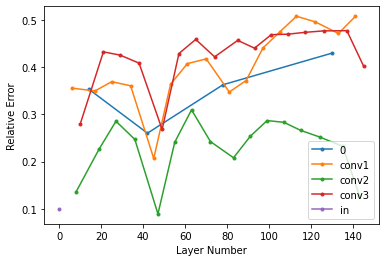

In [26]:
factorization='cp'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_resnet50_cp_50 = copy.deepcopy(resnet50)

factorize_network(
    fact_resnet50_cp_50, 
    layers=resnet50_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
)

process_factorized_network(resnet50, fact_resnet50_cp_50, layer_nrs=resnet50_layers)

## TT

### Rank 50%

In [29]:
factorization='tt'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_resnet50_tt_50 = copy.deepcopy(resnet50)

factorize_network(
    fact_resnet50_tt_50, 
    layers=resnet50_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
)

process_factorized_network(resnet50, fact_resnet50_tt_50, layer_nrs=resnet50_layers)

RuntimeError: The size of tensor a (7) must match the size of tensor b (64) at non-singleton dimension 3

# Wide-ResNet50-2

In [6]:
count_parameters(wide_resnet50_2)

68883240

In [3]:
number_layers(wide_resnet50_2)

NameError: name 'number_layers' is not defined

In [31]:
wrn_layers = [0,6,8,10,14,17,19,21,25,27,29,34,36,38,42,45,47,49,53,55,57,61,63,65,70,72,74,78,81,83,85,89,91,93,97,99,101,105,107,109,113,115,117,122,124,126,130,133,135,137,141,143,145]
# excuding the final layer nr: 149

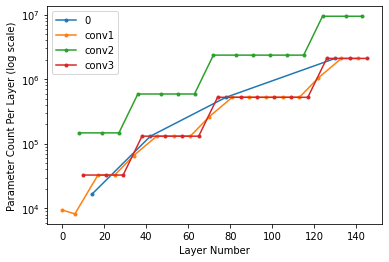

In [32]:
plot_parameters(wide_resnet50_2, wrn_layers)

## Tucker
### Rank 50%

0 conv1 <class 'torch.nn.modules.conv.Conv2d'>
1 bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
2 relu <class 'torch.nn.modules.activation.ReLU'>
3 maxpool <class 'torch.nn.modules.pooling.MaxPool2d'>
4 layer1 <class 'torch.nn.modules.container.Sequential'>
5 0 <class 'torchvision.models.resnet.Bottleneck'>
6 conv1 <class 'torch.nn.modules.conv.Conv2d'>
7 bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
8 conv2 <class 'torch.nn.modules.conv.Conv2d'>
9 bn2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
10 conv3 <class 'torch.nn.modules.conv.Conv2d'>
11 bn3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
12 relu <class 'torch.nn.modules.activation.ReLU'>
13 downsample <class 'torch.nn.modules.container.Sequential'>
14 0 <class 'torch.nn.modules.conv.Conv2d'>
15 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
16 1 <class 'torchvision.models.resnet.Bottleneck'>
17 conv1 <class 'torch.nn.modules.conv.Conv2d'>
18 bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
19 conv2 <

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


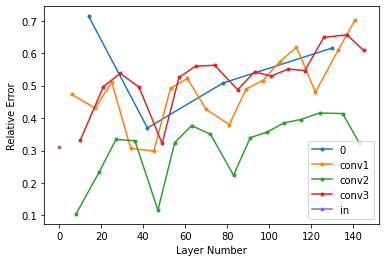

In [ ]:
factorization='tucker'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_wrn_tucker_50 = copy.deepcopy(wide_resnet50_2)

factorize_network(
    fact_wrn_tucker_50, 
    layers=wrn_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    return_error=True,
    verbose=True,
)

process_factorized_network(wide_resnet50_2, fact_wrn_tucker_50, layer_nrs=wrn_layers)

## CP
### Rank 50%

0 conv1 <class 'torch.nn.modules.conv.Conv2d'>
1 bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
2 relu <class 'torch.nn.modules.activation.ReLU'>
3 maxpool <class 'torch.nn.modules.pooling.MaxPool2d'>
4 layer1 <class 'torch.nn.modules.container.Sequential'>
5 0 <class 'torchvision.models.resnet.Bottleneck'>
6 conv1 <class 'torch.nn.modules.conv.Conv2d'>
7 bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
8 conv2 <class 'torch.nn.modules.conv.Conv2d'>
9 bn2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
10 conv3 <class 'torch.nn.modules.conv.Conv2d'>
11 bn3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
12 relu <class 'torch.nn.modules.activation.ReLU'>
13 downsample <class 'torch.nn.modules.container.Sequential'>
14 0 <class 'torch.nn.modules.conv.Conv2d'>
15 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
16 1 <class 'torchvision.models.resnet.Bottleneck'>
17 conv1 <class 'torch.nn.modules.conv.Conv2d'>
18 bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
19 conv2 <

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


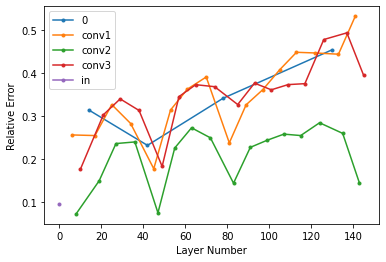

In [33]:
factorization='cp'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_wrn_cp_50 = copy.deepcopy(wide_resnet50_2)

factorize_network(
    fact_wrn_cp_50, 
    layers=wrn_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    return_error=True,
    verbose=True,
)

process_factorized_network(wide_resnet50_2, fact_wrn_cp_50, layer_nrs=wrn_layers)

## TT
### Rank 50%

In [34]:
factorization='tt'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_wrn_tt_50 = copy.deepcopy(wide_resnet50_2)

factorize_network(
    fact_wrn_tt_50, 
    layers=wrn_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    return_error=True,
    verbose=True,
)

process_factorized_network(wide_resnet50_2, fact_wrn_tt_50, layer_nrs=wrn_layers)

0 conv1 <class 'torch.nn.modules.conv.Conv2d'>
1 bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
2 relu <class 'torch.nn.modules.activation.ReLU'>
3 maxpool <class 'torch.nn.modules.pooling.MaxPool2d'>
4 layer1 <class 'torch.nn.modules.container.Sequential'>
5 0 <class 'torchvision.models.resnet.Bottleneck'>
6 conv1 <class 'torch.nn.modules.conv.Conv2d'>
7 bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
8 conv2 <class 'torch.nn.modules.conv.Conv2d'>
9 bn2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
10 conv3 <class 'torch.nn.modules.conv.Conv2d'>
11 bn3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
12 relu <class 'torch.nn.modules.activation.ReLU'>
13 downsample <class 'torch.nn.modules.container.Sequential'>
14 0 <class 'torch.nn.modules.conv.Conv2d'>
15 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
16 1 <class 'torchvision.models.resnet.Bottleneck'>
17 conv1 <class 'torch.nn.modules.conv.Conv2d'>


/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


18 bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
19 conv2 <class 'torch.nn.modules.conv.Conv2d'>
20 bn2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
21 conv3 <class 'torch.nn.modules.conv.Conv2d'>
22 bn3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
23 relu <class 'torch.nn.modules.activation.ReLU'>
24 2 <class 'torchvision.models.resnet.Bottleneck'>
25 conv1 <class 'torch.nn.modules.conv.Conv2d'>
26 bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
27 conv2 <class 'torch.nn.modules.conv.Conv2d'>
28 bn2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
29 conv3 <class 'torch.nn.modules.conv.Conv2d'>
30 bn3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
31 relu <class 'torch.nn.modules.activation.ReLU'>
32 layer2 <class 'torch.nn.modules.container.Sequential'>
33 0 <class 'torchvision.models.resnet.Bottleneck'>
34 conv1 <class 'torch.nn.modules.conv.Conv2d'>
35 bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
36 conv2 <class 'torch.nn.modules.conv.Conv2d'>
37 bn2 <

RuntimeError: The size of tensor a (7) must match the size of tensor b (64) at non-singleton dimension 3

# VGG-16

In [13]:
number_layers(vgg16)

{'features': (0,
  {'0': (1, Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
   '1': (2, ReLU(inplace=True)),
   '2': (3, Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
   '3': (4, ReLU(inplace=True)),
   '4': (5,
    MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
   '5': (6,
    Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
   '6': (7, ReLU(inplace=True)),
   '7': (8,
    Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
   '8': (9, ReLU(inplace=True)),
   '9': (10,
    MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
   '10': (11,
    Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
   '11': (12, ReLU(inplace=True)),
   '12': (13,
    Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
   '13': (14, ReLU(inplace=True)),
   '14': (15,
    Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),


In [14]:
vgg_layers = [1,3,6,8,11,13,15,18,20,22,25,27,29]
# excluding the classifier layers nr: 34, 37 and 40

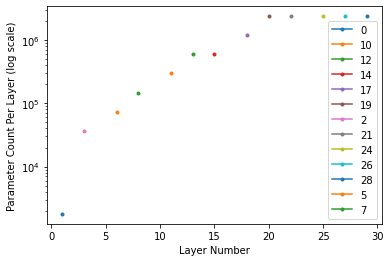

In [15]:
plot_parameters(vgg16, vgg_layers)

## Tucker
### Rank 50%

0 features <class 'torch.nn.modules.container.Sequential'>
1 0 <class 'torch.nn.modules.conv.Conv2d'>
2 1 <class 'torch.nn.modules.activation.ReLU'>
3 2 <class 'torch.nn.modules.conv.Conv2d'>
4 3 <class 'torch.nn.modules.activation.ReLU'>
5 4 <class 'torch.nn.modules.pooling.MaxPool2d'>
6 5 <class 'torch.nn.modules.conv.Conv2d'>
7 6 <class 'torch.nn.modules.activation.ReLU'>
8 7 <class 'torch.nn.modules.conv.Conv2d'>
9 8 <class 'torch.nn.modules.activation.ReLU'>
10 9 <class 'torch.nn.modules.pooling.MaxPool2d'>
11 10 <class 'torch.nn.modules.conv.Conv2d'>
12 11 <class 'torch.nn.modules.activation.ReLU'>
13 12 <class 'torch.nn.modules.conv.Conv2d'>
14 13 <class 'torch.nn.modules.activation.ReLU'>
15 14 <class 'torch.nn.modules.conv.Conv2d'>
16 15 <class 'torch.nn.modules.activation.ReLU'>
17 16 <class 'torch.nn.modules.pooling.MaxPool2d'>
18 17 <class 'torch.nn.modules.conv.Conv2d'>
19 18 <class 'torch.nn.modules.activation.ReLU'>
20 19 <class 'torch.nn.modules.conv.Conv2d'>
21 20 <cla

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


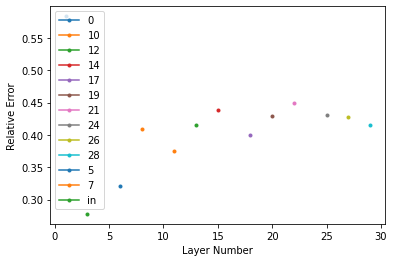

In [19]:
factorization='tucker'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_vgg_tucker_50 = copy.deepcopy(vgg16)

factorize_network(
    fact_vgg_tucker_50, 
    layers=vgg_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    # return_error=True,
    # verbose=True,
)

process_factorized_network(vgg16, fact_vgg_tucker_50, layer_nrs=vgg_layers, first_layer_nr=vgg_layers[0])

## CP
### Rank 50%

In [ ]:
factorization='cp'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_vgg_cp_50 = copy.deepcopy(vgg16)

factorize_network(
    fact_vgg_cp_50, 
    layers=vgg_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    # return_error=True,
    # verbose=True,
)

process_factorized_network(vgg16, fact_vgg_cp_50, layer_nrs=vgg_layers, first_layer_nr=vgg_layers[0])

## TT
### Rank 50%

In [ ]:
factorization='tt'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_vgg_tt_50 = copy.deepcopy(vgg16)

factorize_network(
    fact_vgg_tt_50, 
    layers=vgg_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    # return_error=True,
    verbose=True,
)

process_factorized_network(vgg16, fact_vgg_tt_50, layer_nrs=vgg_layers, first_layer_nr=vgg_layers[0])

# MobileNetV2

In [97]:
number_layers(mobilenet_v2)

{'features': (0,
  {'0': (1,
    {'0': (2,
      Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)),
     '1': (3,
      BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
     '2': (4, ReLU6(inplace=True))}),
   '1': (5,
    {'conv': (6,
      {'0': (7,
        {'0': (8,
          Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)),
         '1': (9,
          BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
         '2': (10, ReLU6(inplace=True))}),
       '1': (11,
        Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)),
       '2': (12,
        BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))})}),
   '2': (13,
    {'conv': (14,
      {'0': (15,
        {'0': (16,
          Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)),
         '1': (17,
          BatchNorm2d(96, eps=1e-05, momentum=0.1, affi

In [98]:

mobilenetv2_layers = [
    2,8,11,16,20,23,28,32,35,40,44,47,52,56,59,64,68,71,76,80,83,88,92,95,100,104,107,112,116,119,124,128,131,136,140,143,148,152,155,160,164,167,172,176,179,184,188,191,196,200,203,206
]
# excl. classification layer nr: 211

In [ ]:
plot_parameters(mobilenet_v2, mobilenetv2_layers)

## Tucker
### Rank 50%

0 features <class 'torch.nn.modules.container.Sequential'>
1 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
2 0 <class 'torch.nn.modules.conv.Conv2d'>
3 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
4 2 <class 'torch.nn.modules.activation.ReLU6'>
5 1 <class 'torchvision.models.mobilenetv2.InvertedResidual'>
6 conv <class 'torch.nn.modules.container.Sequential'>
7 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
8 0 <class 'torch.nn.modules.conv.Conv2d'>
9 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
10 2 <class 'torch.nn.modules.activation.ReLU6'>
11 1 <class 'torch.nn.modules.conv.Conv2d'>
12 2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
13 2 <class 'torchvision.models.mobilenetv2.InvertedResidual'>
14 conv <class 'torch.nn.modules.container.Sequential'>
15 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
16 0 <class 'torch.nn.modules.conv.Conv2d'>
17 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
18 2 <class 'torch.nn.modules.act

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


72 3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
73 7 <class 'torchvision.models.mobilenetv2.InvertedResidual'>
74 conv <class 'torch.nn.modules.container.Sequential'>
75 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
76 0 <class 'torch.nn.modules.conv.Conv2d'>
77 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
78 2 <class 'torch.nn.modules.activation.ReLU6'>
79 1 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
80 0 <class 'torch.nn.modules.conv.Conv2d'>
81 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
82 2 <class 'torch.nn.modules.activation.ReLU6'>
83 2 <class 'torch.nn.modules.conv.Conv2d'>
84 3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
85 8 <class 'torchvision.models.mobilenetv2.InvertedResidual'>
86 conv <class 'torch.nn.modules.container.Sequential'>
87 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
88 0 <class 'torch.nn.modules.conv.Conv2d'>
89 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
90 2 <class 'torch.nn.modules

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


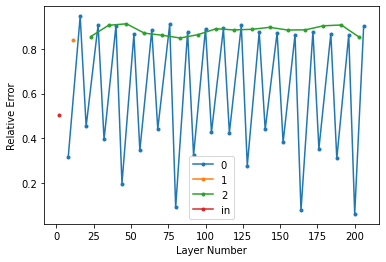

In [ ]:
factorization='tucker'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_mobilenetv2_tucker_50 = copy.deepcopy(mobilenet_v2)

factorize_network(
    fact_mobilenetv2_tucker_50, 
    layers=mobilenetv2_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    # return_error=True,
    # verbose=True,
)

process_factorized_network(mobilenet_v2, fact_mobilenetv2_tucker_50, layer_nrs=mobilenetv2_layers)

## CP
### Rank 50%

0 features <class 'torch.nn.modules.container.Sequential'>
1 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
2 0 <class 'torch.nn.modules.conv.Conv2d'>
3 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
4 2 <class 'torch.nn.modules.activation.ReLU6'>
5 1 <class 'torchvision.models.mobilenetv2.InvertedResidual'>
6 conv <class 'torch.nn.modules.container.Sequential'>
7 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
8 0 <class 'torch.nn.modules.conv.Conv2d'>
9 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
10 2 <class 'torch.nn.modules.activation.ReLU6'>
11 1 <class 'torch.nn.modules.conv.Conv2d'>
12 2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
13 2 <class 'torchvision.models.mobilenetv2.InvertedResidual'>
14 conv <class 'torch.nn.modules.container.Sequential'>
15 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
16 0 <class 'torch.nn.modules.conv.Conv2d'>
17 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
18 2 <class 'torch.nn.modules.act

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


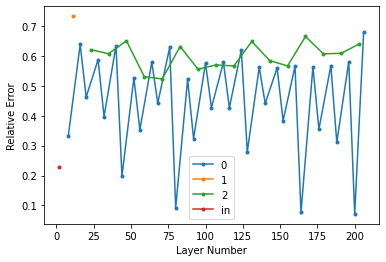

In [101]:
factorization='cp'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_mobilenetv2_cp_50 = copy.deepcopy(mobilenet_v2)

factorize_network(
    fact_mobilenetv2_cp_50, 
    layers=mobilenetv2_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    # return_error=True,
    # verbose=True,
)

process_factorized_network(mobilenet_v2, fact_mobilenetv2_cp_50, layer_nrs=mobilenetv2_layers)

## TT
### Rank 50%

In [102]:
factorization='tt'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_mobilenetv2_tt_50 = copy.deepcopy(mobilenet_v2)

factorize_network(
    fact_mobilenetv2_tt_50, 
    layers=mobilenetv2_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    # return_error=True,
    # verbose=True,
)

process_factorized_network(mobilenet_v2, fact_mobilenetv2_tt_50, layer_nrs=mobilenetv2_layers)

0 features <class 'torch.nn.modules.container.Sequential'>
1 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
2 0 <class 'torch.nn.modules.conv.Conv2d'>
3 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
4 2 <class 'torch.nn.modules.activation.ReLU6'>
5 1 <class 'torchvision.models.mobilenetv2.InvertedResidual'>
6 conv <class 'torch.nn.modules.container.Sequential'>
7 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
8 0 <class 'torch.nn.modules.conv.Conv2d'>
9 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
10 2 <class 'torch.nn.modules.activation.ReLU6'>
11 1 <class 'torch.nn.modules.conv.Conv2d'>
12 2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
13 2 <class 'torchvision.models.mobilenetv2.InvertedResidual'>
14 conv <class 'torch.nn.modules.container.Sequential'>
15 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
16 0 <class 'torch.nn.modules.conv.Conv2d'>
17 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
18 2 <class 'torch.nn.modules.act

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


144 3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
145 13 <class 'torchvision.models.mobilenetv2.InvertedResidual'>
146 conv <class 'torch.nn.modules.container.Sequential'>
147 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
148 0 <class 'torch.nn.modules.conv.Conv2d'>
149 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
150 2 <class 'torch.nn.modules.activation.ReLU6'>
151 1 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
152 0 <class 'torch.nn.modules.conv.Conv2d'>
153 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
154 2 <class 'torch.nn.modules.activation.ReLU6'>
155 2 <class 'torch.nn.modules.conv.Conv2d'>
156 3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
157 14 <class 'torchvision.models.mobilenetv2.InvertedResidual'>
158 conv <class 'torch.nn.modules.container.Sequential'>
159 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
160 0 <class 'torch.nn.modules.conv.Conv2d'>
161 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
162 2 <cl

RuntimeError: The size of tensor a (3) must match the size of tensor b (32) at non-singleton dimension 3

# MobileNetV3-small

In [91]:
number_layers(mobilenet_v3_small)

{'features': (0,
  {'0': (1,
    {'0': (2,
      Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)),
     '1': (3,
      BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)),
     '2': (4, Hardswish())}),
   '1': (5,
    {'block': (6,
      {'0': (7,
        {'0': (8,
          Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)),
         '1': (9,
          BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)),
         '2': (10, ReLU(inplace=True))}),
       '1': (11,
        {'fc1': (12, Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))),
         'relu': (13, ReLU(inplace=True)),
         'fc2': (14, Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1)))}),
       '2': (15,
        {'0': (16,
          Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)),
         '1': (17,
          BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=T

In [92]:
mobilenet_v3_small_layers = [
    2,8,12,14,16,22,26,30,36,40,44,50,54,58,60,62,68,72,76,78,80,86,90,94,96,98,104,108,112,114,116,122,126,129,130,132,134,140,144,148,150,152,158,162,166,168,170,176,180,184,186,188,192
]
# excluding classifier layers nr: 197 and 200

In [ ]:
plot_parameters(mobilenet_v3_small, mobilenet_v3_small_layers)

## Tucker
### Rank 50%

In [93]:
factorization='tucker'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_mobilenetv3_tucker_50 = copy.deepcopy(mobilenet_v3_small)

factorize_network(
    fact_mobilenetv3_tucker_50, 
    layers=mobilenet_v3_small_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    return_error=True,
    verbose=True,
)

process_factorized_network(mobilenet_v3_small, fact_mobilenetv3_tucker_50, layer_nrs=mobilenet_v3_small_layers)

0 features <class 'torch.nn.modules.container.Sequential'>
1 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
2 0 <class 'torch.nn.modules.conv.Conv2d'>
3 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
4 2 <class 'torch.nn.modules.activation.Hardswish'>
5 1 <class 'torchvision.models.mobilenetv3.InvertedResidual'>
6 block <class 'torch.nn.modules.container.Sequential'>
7 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
8 0 <class 'torch.nn.modules.conv.Conv2d'>
9 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
10 2 <class 'torch.nn.modules.activation.ReLU'>
11 1 <class 'torchvision.models.mobilenetv3.SqueezeExcitation'>
12 fc1 <class 'torch.nn.modules.conv.Conv2d'>
13 relu <class 'torch.nn.modules.activation.ReLU'>
14 fc2 <class 'torch.nn.modules.conv.Conv2d'>
15 2 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
16 0 <class 'torch.nn.modules.conv.Conv2d'>
17 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
18 2 <class 'torch.nn.modules.linear.Id

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'
/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tensorly/backend/core.py:916: RuntimeWarning: invalid value encountered in sqrt
  S = np.where(np.abs(S) <= np.finfo(S.dtype).eps, 0, np.sqrt(S))
/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tensorly/backend/core.py:917: RuntimeWarning: divide by zero encountered in true_divide
  U = np.dot(matrix, V) * np.where(np.abs(S) <= np.finfo(S.dtype).eps, 0, 1/S)[None, :]
/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/tensorly/backend/core.py:910: RuntimeWarning: invalid value encountered in sqrt
  S = np.where(np.abs(S) <= np.finfo(S.dtype).eps, 0, np.sqrt(S))
/home/jetzeschuurman/gitProj

ValueError: array must not contain infs or NaNs

## CP
### Rank 50%

In [94]:
factorization='cp'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_mobilenetv3_cp_50 = copy.deepcopy(mobilenet_v3_small)

factorize_network(
    fact_mobilenetv3_cp_50, 
    layers=mobilenet_v3_small_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    return_error=True,
    verbose=True,
)

process_factorized_network(mobilenet_v3_small, fact_mobilenetv3_cp_50, layer_nrs=mobilenet_v3_small_layers)

0 features <class 'torch.nn.modules.container.Sequential'>
1 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
2 0 <class 'torch.nn.modules.conv.Conv2d'>
3 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
4 2 <class 'torch.nn.modules.activation.Hardswish'>
5 1 <class 'torchvision.models.mobilenetv3.InvertedResidual'>
6 block <class 'torch.nn.modules.container.Sequential'>
7 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
8 0 <class 'torch.nn.modules.conv.Conv2d'>
9 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
10 2 <class 'torch.nn.modules.activation.ReLU'>
11 1 <class 'torchvision.models.mobilenetv3.SqueezeExcitation'>
12 fc1 <class 'torch.nn.modules.conv.Conv2d'>
13 relu <class 'torch.nn.modules.activation.ReLU'>
14 fc2 <class 'torch.nn.modules.conv.Conv2d'>
15 2 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
16 0 <class 'torch.nn.modules.conv.Conv2d'>
17 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
18 2 <class 'torch.nn.modules.linear.Id

NotImplementedError: <class 'torchvision.models.mobilenetv3.SqueezeExcitation'>

## TT
### Rank 50%

In [95]:
factorization='tt'
rank=0.5
decomposition_kwargs = {'init': 'random'} if factorization == 'cp' else {}
fixed_rank_modes = 'spatial' if factorization == 'tucker' else None

fact_mobilenetv3_tt_50 = copy.deepcopy(mobilenet_v3_small)

factorize_network(
    fact_mobilenetv3_tt_50, 
    layers=mobilenet_v3_small_layers,
    factorization=factorization,
    rank=rank,
    decompose_weights=decompose_weights,
    return_error=True,
    verbose=True,
)

process_factorized_network(mobilenet_v3_small, fact_mobilenetv3_tt_50, layer_nrs=mobilenet_v3_small_layers)

0 features <class 'torch.nn.modules.container.Sequential'>
1 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
2 0 <class 'torch.nn.modules.conv.Conv2d'>
3 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
4 2 <class 'torch.nn.modules.activation.Hardswish'>
5 1 <class 'torchvision.models.mobilenetv3.InvertedResidual'>
6 block <class 'torch.nn.modules.container.Sequential'>
7 0 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
8 0 <class 'torch.nn.modules.conv.Conv2d'>
9 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
10 2 <class 'torch.nn.modules.activation.ReLU'>
11 1 <class 'torchvision.models.mobilenetv3.SqueezeExcitation'>
12 fc1 <class 'torch.nn.modules.conv.Conv2d'>
13 relu <class 'torch.nn.modules.activation.ReLU'>
14 fc2 <class 'torch.nn.modules.conv.Conv2d'>
15 2 <class 'torchvision.models.mobilenetv2.ConvBNActivation'>
16 0 <class 'torch.nn.modules.conv.Conv2d'>
17 1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
18 2 <class 'torch.nn.modules.linear.Id

NotImplementedError: <class 'torchvision.models.mobilenetv3.SqueezeExcitation'>